# 13_10 인공 신경망 (CNN, RNN, LSTM)

In [1]:
import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, LSTM
from keras.layers.convolutional import Convolution2D, MaxPooling2D
import sys
from sklearn.preprocessing import MinMaxScaler
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [8]:
# CNN 모델 생성

# CNN 모델 생성

# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#데이터를 10,000개로 제한
(x_train, y_train), (x_test, y_test) = (x_train[:10000], y_train[:10000]
                                       ), (x_test[:10000], y_test[:10000])

input_shape = (28, 28, 1)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# 데이터 정규화
x_train = x_train.astype('float') / 255.
x_test = x_test.astype('float') / 255.

# 학습셋, 테스트셋 형태 출력
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

# 학습셋, 테스트셋 범주 10 설정
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# CNN 모델 구축 -은닉층 생성
model = Sequential()
model.add(Convolution2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', input_shape=(28, 28, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Convolution2D(64, (2, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

# CNN 컴파일
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', metrics=['accuracy'])

model.summary()

x_train shape: (10000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 activation_4 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        8256      
                                                                 
 activation_5 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)       

Epoch 1/5
264/264 [==============================] - 4s 15ms/step - loss: 0.1083 - accuracy: 0.8101 - val_loss: 0.0281 - val_accuracy: 0.9608
Epoch 2/5
264/264 [==============================] - 4s 15ms/step - loss: 0.0317 - accuracy: 0.9569 - val_loss: 0.0193 - val_accuracy: 0.9732
Epoch 3/5
264/264 [==============================] - 4s 16ms/step - loss: 0.0219 - accuracy: 0.9706 - val_loss: 0.0156 - val_accuracy: 0.9749
Epoch 4/5
264/264 [==============================] - 4s 15ms/step - loss: 0.0177 - accuracy: 0.9765 - val_loss: 0.0123 - val_accuracy: 0.9800
Epoch 5/5
264/264 [==============================] - 4s 15ms/step - loss: 0.0153 - accuracy: 0.9772 - val_loss: 0.0107 - val_accuracy: 0.9825
Test accuracy: 0.9825000166893005
313/313 [==============================] - 1s 3ms/step


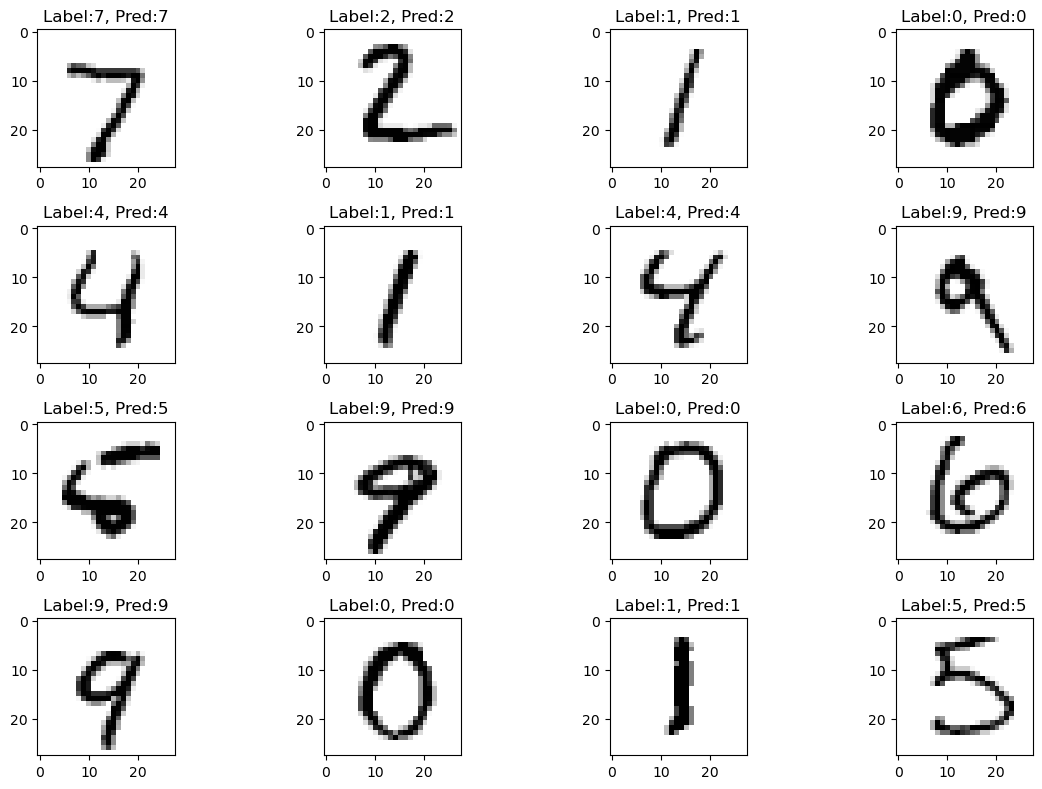

In [9]:
# CNN 모델 결과 출력

# 모델 적합 (반복횟수 5)
model_fit = model.fit(x_train, y_train, batch_size=38, epochs=5, verbose=1
                      , validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

# 모델 정확도 출력
print('Test accuracy:', score[1])

# 샘플 결과 확인
pred_test = model.predict(x_test)
pred_test_y = np.argmax(pred_test, axis=1)
test_y = np.argmax(y_test, axis=1)

count = 0

plt.figure(figsize=(12,8))
for n in range(16):
    count += 1
    plt.subplot(4, 4, count)
    plt.imshow(x_test[n].reshape(28, 28), cmap='binary', interpolation='nearest')
    sample_result = "Label:" + str(test_y[n]) + ", Pred:" + str(pred_test_y[n])
    plt.title(sample_result)
plt.tight_layout()

plt.show()

In [6]:
#################### RNN과 LSTM #######################

In [10]:
# 데이터 불러오기
# https://www.kaggle.com/datasets/medharawat/google-stock-price

df_train = pd.read_csv('/Users/adam/Data_Analytics/Python/Datasets/google_stock_price/Google_Stock_Price_Train.csv')
df_test = pd.read_csv('/Users/adam/Data_Analytics/Python/Datasets/google_stock_price/Google_Stock_Price_Test.csv')

# 데이터 샘플 확인
df_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [13]:
# RNN과 LSTM으로 구글 주가예측 시계열 모델 만들기 

# 데이터 정규화 및 numpy 배열 변환

df_train_array = df_train.iloc[:, 1:2].values
scaler = MinMaxScaler(feature_range = (0,1))
df_train_array_scaled = scaler.fit_transform(df_train_array)

x_train = []
y_train = []
for i in range(60, 1258):
# 독립변수와 종속변수 생성 - 60일 시간차
    x_train.append(df_train_array_scaled[i-60:i, 0])
    y_train.append(df_train_array_scaled[i, 0])
    
# numpy 배열로 변환
x_train, y_train = np.array(x_train), np.array(y_train)

# 새로운 차원 추가
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

(1198, 60, 1)


In [14]:
# RNN 모델에 LSTM 레이어 추가하여 모델 생성 및 학습

# 모델 설정
RL_model = Sequential()
epochs = 100
batch_size = 28

# 첫 번째 LSTM 레이어 및 일부 Dropout 정규화 추가
RL_model.add(LSTM( units = 50, 
                  return_sequences = True, input_shape = (x_train.shape[1], 1) ))
# Ignore 20% of the neurons
RL_model.add(Dropout(0.2))

# 두 번째 LSTM 레이어 및 일부 Dropout 정규화 추가
RL_model.add(LSTM(units = 50, return_sequences = True))
RL_model.add(Dropout(0.2))

# 세 번째 LSTM 레이어 및 일부 Dropout 정규화 추가
RL_model.add(LSTM(units = 50, return_sequences = True))
RL_model.add(Dropout(0.2))

# 네 번째 LSTM 레이어 및 일부 Dropout 정규화 추가
RL_model.add(LSTM(units = 50))
RL_model.add(Dropout(0.2))

# 출력 레이어 추가
RL_model.add(Dense(units = 1))

# RNN 컴파일
RL_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 학습셋에 RNN(LSTM) 모델 적용
RL_model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/100
43/43 [==============================] - 3s 36ms/step - loss: 0.0453
Epoch 2/100
43/43 [==============================] - 2s 36ms/step - loss: 0.0060
Epoch 3/100
43/43 [==============================] - 2s 36ms/step - loss: 0.0050
Epoch 4/100
43/43 [==============================] - 2s 36ms/step - loss: 0.0049
Epoch 5/100
43/43 [==============================] - 2s 38ms/step - loss: 0.0051
Epoch 6/100
43/43 [==============================] - 2s 40ms/step - loss: 0.0053
Epoch 7/100
43/43 [==============================] - 2s 40ms/step - loss: 0.0045
Epoch 8/100
43/43 [==============================] - 2s 40ms/step - loss: 0.0050
Epoch 9/100
43/43 [==============================] - 2s 40ms/step - loss: 0.0051
Epoch 10/100
43/43 [==============================] - 2s 39ms/step - loss: 0.0043
Epoch 11/100
43/43 [==============================] - 2s 37ms/step - loss: 0.0044
Epoch 12/100
43/43 [==============================] - 2s 36ms/step - loss: 0.0041
Epoch 13/100
43/43 [=====

1/1 [==============================] - 0s 384ms/step


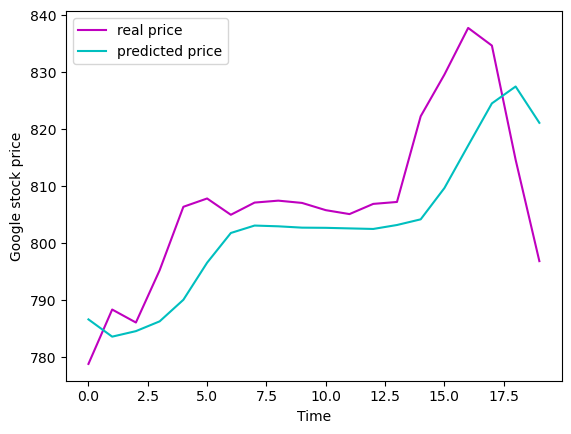

In [15]:
# 예측 및 결과 시각화

df_test_array = df_test.iloc[:, 1:2].values

# 학습 세트와 테스트 세트 결합
dataset_total = pd.concat( (df_train['Open'], df_test['Open']), axis = 0 )

# 마지막 60일 기간 분리
y_test = dataset_total[len(dataset_total) - len(df_test) -60:].values

# 데이터를 하나의 열로 가공
y_test = y_test.reshape(-1, 1)

# 테스트 세트 정규화 적용
y_test = scaler.transform(y_test)

# 60일 데이터 구조 생성
x_test = []
for i in range(60, 80):
    x_test.append(y_test[i-60:i, 0])
x_test = np.array(x_test)

# 새로운 차원 추가
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 예측값 산출
predicted_stock_price = RL_model.predict(x_test)

# 정규화된 값을 기존 값으로 재 변환
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# 결과 값 시각화
plt.plot(df_test_array, color = 'm', label = 'real price')
plt.plot(predicted_stock_price, color = 'c', label = 'predicted price')
plt.xlabel('Time')
plt.ylabel('Google stock price')
plt.legend()
plt.show()